In [1]:
# Code from 
import torch
import math

dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
x = torch.linspace(-math.pi, math.pi, 2000, dtype=dtype)
y = torch.sin(x)

# Create random Tensors for weights. For a third order polynomial, we need
# 4 weights: y = a + b x + c x^2 + d x^3
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.randn((), dtype=dtype, requires_grad=True)
b = torch.randn((), dtype=dtype, requires_grad=True)
c = torch.randn((), dtype=dtype, requires_grad=True)
d = torch.randn((), dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y using operations on Tensors.
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

/home/jessica/miniconda3/envs/torch-test/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


99 3241.00341796875
199 2154.9326171875
299 1434.1907958984375
399 955.7715454101562
499 638.1229858398438
599 427.16217041015625
699 287.0163269042969
799 193.88629150390625
899 131.97970581054688
999 90.81423950195312
1099 63.43096923828125
1199 45.208953857421875
1299 33.07820510864258
1399 24.999181747436523
1499 19.616113662719727
1599 16.027786254882812
1699 13.634577751159668
1799 12.037644386291504
1899 10.971467018127441
1999 10.259202003479004
Result: y = 0.017292935401201248 + 0.823417603969574 x + -0.0029833188746124506 x^2 + -0.08859045058488846 x^3


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("stock-data.csv")
df.info()
df.drop("Date", inplace=True, axis = 1)
df = df.replace(",","", regex = True)
df = df.astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    946 non-null    object 
 1   Open    946 non-null    float64
 2   High    946 non-null    float64
 3   Low     946 non-null    float64
 4   Close   946 non-null    float64
dtypes: float64(4), object(1)
memory usage: 37.1+ KB


In [3]:
data_ouput = df[["Close"]]
data_input = df[["Open", "High", "Low"]]

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler(feature_range=(-1, 1))
scaler_x = MinMaxScaler(feature_range=(-1, 1))
data_ouput["Close"] = scaler_y.fit_transform(data_ouput["Close"].values.reshape(-1,1))
data_input= scaler_x.fit_transform(data_input.values.reshape(-1,3))

/tmp/ipykernel_349772/1129276569.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ouput["Close"] = scaler_y.fit_transform(data_ouput["Close"].values.reshape(-1,1))


In [5]:
print(data_ouput.shape)
print(data_input.shape)

(946, 1)
(946, 3)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class stockPredictorLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(stockPredictorLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.float()
    #goes through each layer of the neural netwrok and returns an answer depending
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

model = stockPredictorLSTM(input_dim = 3,hidden_dim=50,num_layers = 3,output_dim = 1)

In [7]:
def split_data(input, output, lookback):
    data_in = []
    for index in range(len(input) - lookback): 
        data_in.append(input[index: index + lookback])
    
    dataOutput = output.to_numpy()
    data_out = []
    for index in range(len(dataOutput) - lookback): 
        data_out.append(dataOutput[index: index + lookback])
    
    data_in = np.array(data_in)
    data_out = np.array(data_out)
    
    test_set_size = int(np.round(0.25*data_in.shape[0]))
    train_set_size = data_in.shape[0] - (test_set_size)
    
    x_train = data_in[:train_set_size,:-1,:]
    y_train = data_out[:train_set_size,-1,:]
    
    x_test = data_in[train_set_size:,:-1]
    y_test = data_out[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 21
x_train, y_train, x_test, y_test = split_data(data_input, data_ouput, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (694, 20, 3)
y_train.shape =  (694, 1)
x_test.shape =  (231, 20, 3)
y_test.shape =  (231, 1)


In [8]:
torch.set_default_dtype(torch.float32)

x_train_lstm = torch.from_numpy(x_train).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

x_test_lstm = torch.from_numpy(x_test).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [9]:
print(x_train_lstm.dtype)

torch.float32


In [10]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adamax(model.parameters(), lr = 0.01)

epochs = 400
hist = np.zeros(epochs)
for epoch in range(epochs):
    y_train_pred = model.forward(x_train_lstm)

    loss = criterion(y_train_pred, y_train_lstm)
    if (epoch +1) %100 ==0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    hist[epoch] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/home/jessica/miniconda3/envs/torch-test/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 99, Loss: 0.004614670295268297
Epoch 199, Loss: 0.0033639755565673113
Epoch 299, Loss: 0.0023769645486027002
Epoch 399, Loss: 0.0022999716456979513


In [11]:
actuals = pd.DataFrame(scaler_y.inverse_transform(y_train_lstm.numpy()))
preds = pd.DataFrame(scaler_y.inverse_transform(y_train_pred.detach().numpy()))

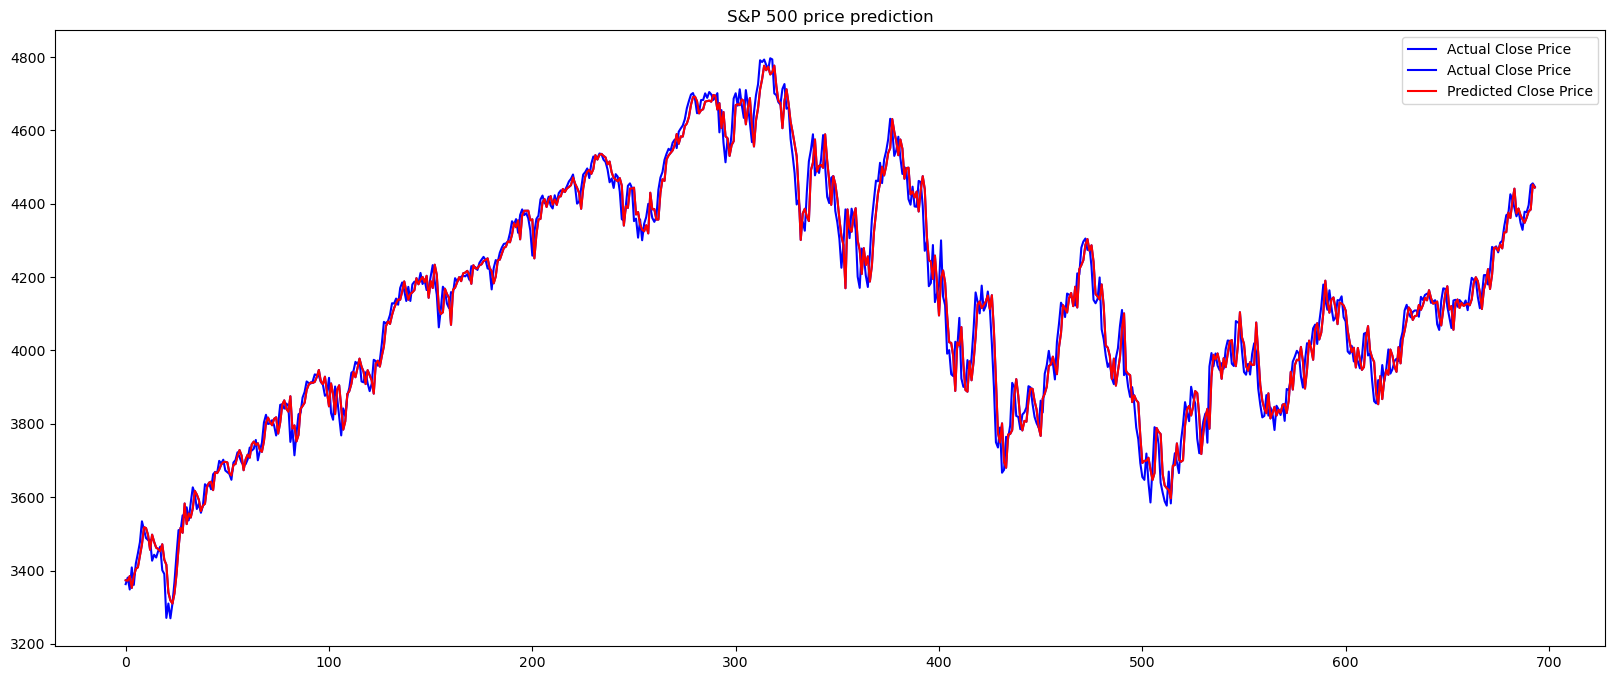

In [12]:
#Plot all predictions
import matplotlib.pyplot as plt

train = data_ouput[0:len(actuals)]
valid = actuals
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(valid, color = 'blue', label = 'Actual Close Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Close Price')
plt.title('S&P 500 price prediction')
plt.legend()
plt.show()

In [13]:
# make predictions
y_test_pred = model(x_test_lstm)

# invert predictions
y_train_pred = scaler_y.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler_y.inverse_transform(y_train_lstm.detach().numpy())

y_test_pred = scaler_y.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler_y.inverse_transform(y_test_lstm.detach().numpy())

          actual    predicted
0    4444.793457  4411.589844
1    4399.570312  4398.949707
2    4429.921875  4409.530273
3    4397.012695  4439.259766
4    4437.958984  4472.160156
..           ...          ...
226  5176.132324  5266.950195
227  5151.675293  5235.479980
228  5134.313965  5277.510254
229  5126.062012  5283.399902
230  5153.076172  5291.339844

[231 rows x 2 columns]


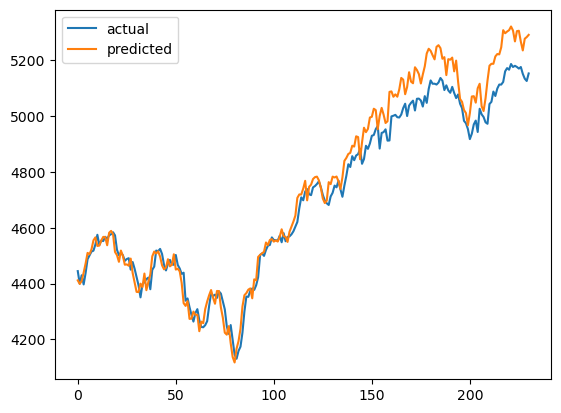

In [14]:
#Shift test predictions for plotting
results_dataframe = pd.concat([pd.DataFrame(y_test_pred), pd.DataFrame(y_test)],axis = 1, ignore_index = True)
results_dataframe.columns =['actual', 'predicted']
print(results_dataframe)

results_dataframe.plot(y=["actual", "predicted"])
plt.show()


In [18]:
torch.save(model.state_dict(), "SP500Pricing")
torch.save(model, "stockpricing_complete")

In [16]:
# model = torch.load("/home/jessica/Project Code/NeuralNetworkPractice/stockpricing_complete")
# model.eval()